<a href="https://colab.research.google.com/github/raulbenitez/MITO_FIBERS/blob/master/Segment_x63_casos_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Grant Drive permissions:

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


Load modules:

In [0]:
module1 = drive.CreateFile({'id':'1T7HwuRQCguNXXp9YSQ05k3a2DJA5owJM'})
module2 = drive.CreateFile({'id':'1aeITIgFb6Ei3LDFQ5rPB3rgSV4dhcgM3'})
module3 = drive.CreateFile({'id':'1Sz3XOztm-4iDdsJDdklEHuiJiXUFgA5T'})

In [0]:
module1.GetContentFile('model_tf_keras.py')
module2.GetContentFile('functions.py')
module3.GetContentFile('read_lif.py')

In [0]:
from skimage import measure
from sklearn import mixture

def _ratio(r,b,bw):  
    r = (r*bw)+0.0001
    b = (b*bw)

    label_image = measure.label(bw)
    data_ratio = b/r
    #data_ratio[data_ratio==0] = np.nan

    mean_ratio = []
    fiberI = np.unique(label_image)

    for kfiber in fiberI:
        fiber = data_ratio*(label_image==kfiber)
        fiber[fiber==0] = np.nan
        mean_ratio.append(np.nanmean(fiber))
    mean_ratio = np.array(mean_ratio)
    mean_ratio[mean_ratio>1.2]=np.nan
    #savepath = 'NumpyArrays/mean_ratio.npy'
    #np.save(savepath, mean_ratio)
    
    return(mean_ratio,label_image,fiberI)


def remove_nan(mean_ratio, fiberI):
    nanI = np.argwhere(np.isnan(mean_ratio)).flatten()
    fiberI1 = np.delete(fiberI,nanI)
    mean_ratio1 = np.delete(mean_ratio,nanI)
    return(nanI,fiberI1,mean_ratio1)

def sort_clf_means(Y, clf):
    Y1 = np.zeros(Y.shape)
    clf_means = np.zeros(clf.means_.shape)
    clfI = np.flip(np.argsort(clf.means_.flatten()))

    for i in range(len(clf.means_)):
        Y1[Y==i]=np.argwhere(clfI==i).flatten()+1
        clf_means[i]=clf.means_[clfI[i]]

    return Y1, clf_means, clfI

#def fitGMM(mean_ratio, fiberI):
def fitGMM(mean_ratio):

    #nanI,fiberI1,mean_ratio1 = remove_nan(mean_ratio, fiberI)
    #X = mean_ratio1.reshape(-1,1)
      
    X = mean_ratio1.reshape(-1,1)
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 3)
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components, covariance_type='full')
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

    bic = np.array(bic)
    clf = best_gmm

    Y = clf.predict(X)
    
    Y1, clf_means, clfI = sort_clf_means(Y, clf)
    
    return(X, Y1, clf_means, clfI, clf)
   
def showHistAndGMM_save(X,clf,clfI,clf_means,save_path):
    ccolor = [[1, 1, 1], [0, 0.8, 0], [0, 0, 1], [0, 0.7, 1], [1, 0.4, 0], [1, 0, 1], [0.7, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0]]

    fig = plt.figure(figsize=(5, 4), dpi=100)
    #t = np.arange(0, 3, .01)
    ax1 = fig.add_subplot(111)
    
    x = np.linspace(0, 1.2, 1200)
    logprob = clf.score_samples(x.reshape(-1, 1))
    responsibilities = clf.predict_proba(x.reshape(-1, 1))
    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]

    for i in range(pdf_individual.shape[1]):
        ax1.plot(x, pdf_individual[:,clfI[i]], color=ccolor[i+1], label='Component '+str(i+1)+' - mean: '+str(np.round_(clf.means_[clfI[i]],4)))
    
    ax1.plot(x, pdf, '-k', label='Complete GMM' )
    ax1.hist(X, density=True, label='Histogram')
    
    ax1.legend()

    #ax.hist(X, 30, density=True, histtype='stepfilled', alpha=0.4)
    #ax.plot(x, pdf_individual)
    #ax.text(0.04, 0.96, "Best-fit Mixture", ha='left', va='top', transform=ax.transAxes)
    ax1.set_xlabel('Ratio Blue/Red')
    #ax.set_ylabel('$p(x)$')
    ax1.set_title('Histogram and GMM (' + str(X.shape[0])+ ' fibers)')
    plt.savefig(save_path)
    #plt.show()    

def pred_gmm(Y1,label_image,fiberI1):
    pred_gmm_image = np.zeros(label_image.shape)
    for kfiber in range(len(fiberI1)):
        pred_gmm_image += (Y1[kfiber])*(label_image==fiberI1[kfiber]) 
    return(pred_gmm_image)


Segment x63 fibers:

Caso = 1
Campo = /content/drive/My Drive/MITO_FIBERS_x63/Segmentation_Unet/Data/63x/Patients/Lif/Caso1_NDBFU8_Oxphos_Porin_C101.lif
1/1 [==============================] - 0s 2ms/step
Added 6 fibers in field /content/drive/My Drive/MITO_FIBERS_x63/Segmentation_Unet/Data/63x/Patients/Lif/Caso1_NDBFU8_Oxphos_Porin_C101.lif
total number of fibers = 6
Campo = /content/drive/My Drive/MITO_FIBERS_x63/Segmentation_Unet/Data/63x/Patients/Lif/Caso1_NDBFU8_Oxphos_Porin_C102.lif
1/1 [==============================] - 0s 1ms/step
Added 18 fibers in field /content/drive/My Drive/MITO_FIBERS_x63/Segmentation_Unet/Data/63x/Patients/Lif/Caso1_NDBFU8_Oxphos_Porin_C102.lif
total number of fibers = 24
Campo = /content/drive/My Drive/MITO_FIBERS_x63/Segmentation_Unet/Data/63x/Patients/Lif/Caso1_NDBFU8_Oxphos_Porin_C104.lif
1/1 [==============================] - 0s 1ms/step
Added 9 fibers in field /content/drive/My Drive/MITO_FIBERS_x63/Segmentation_Unet/Data/63x/Patients/Lif/Caso1_NDBFU8_Oxphos_Porin_C104.

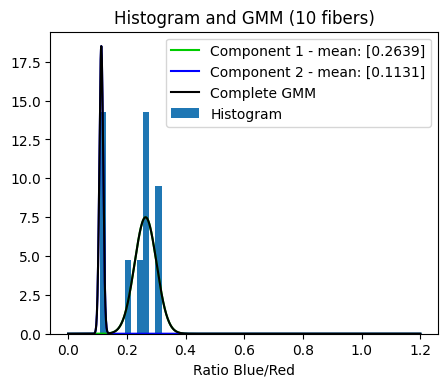

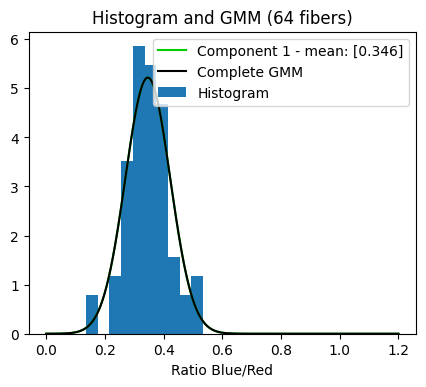

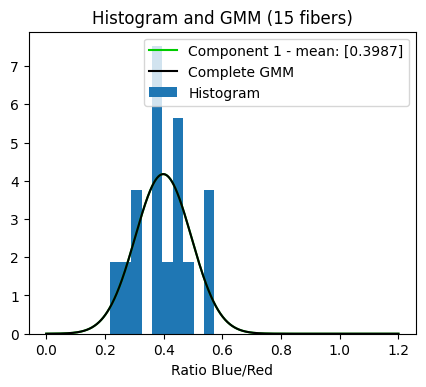

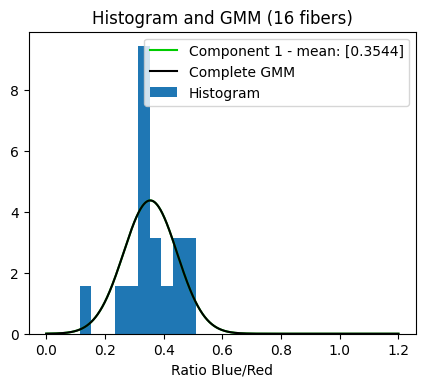

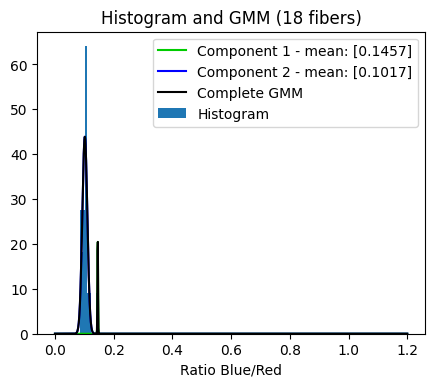

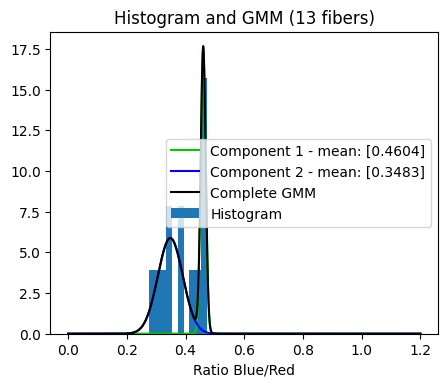

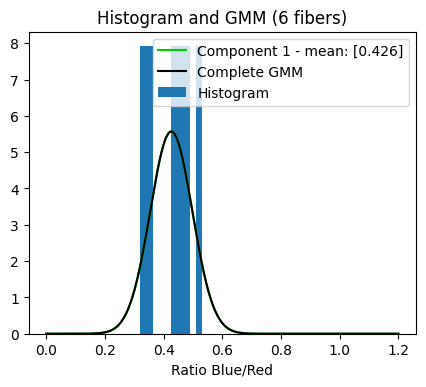

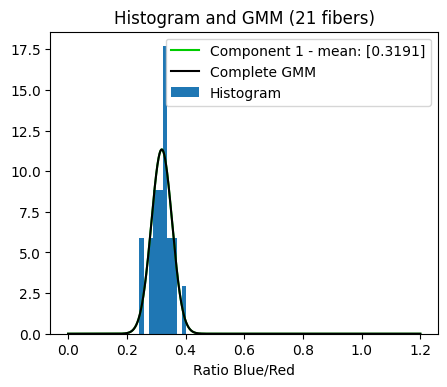

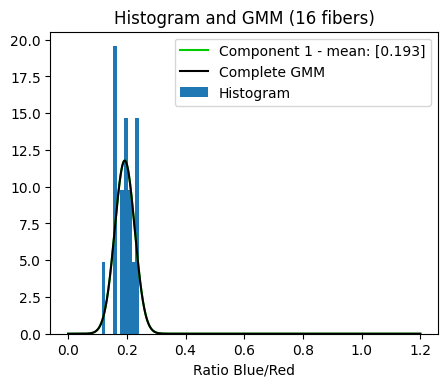

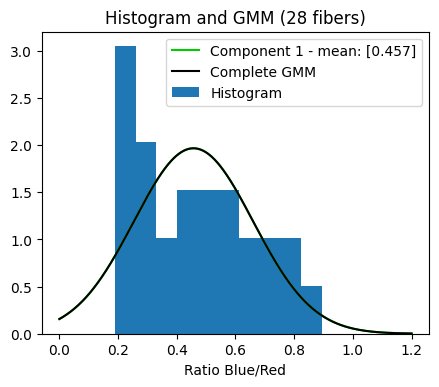

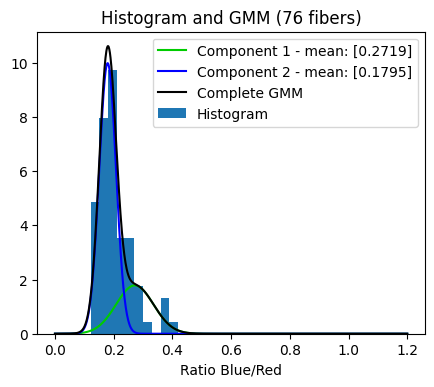

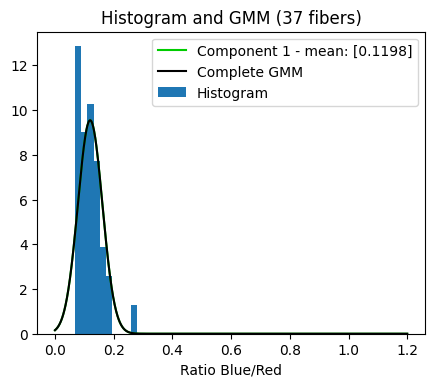

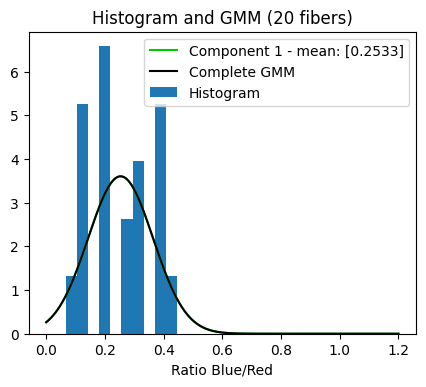

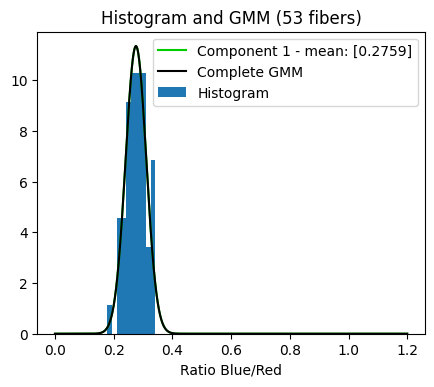

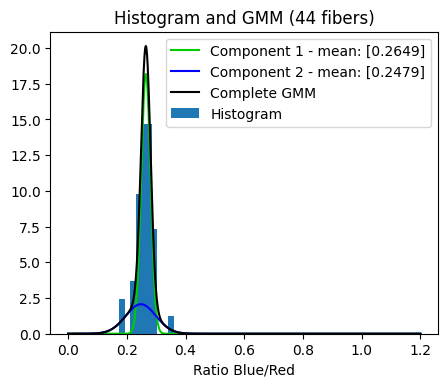

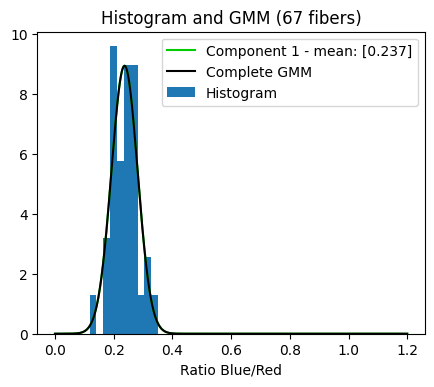

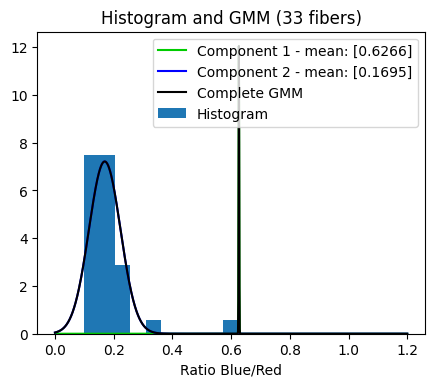

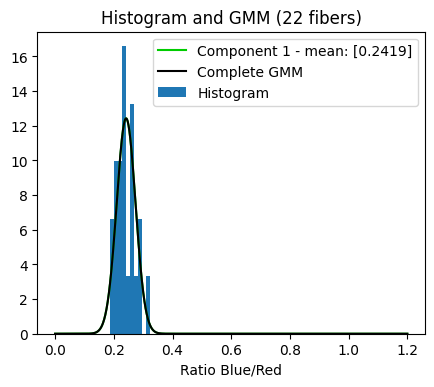

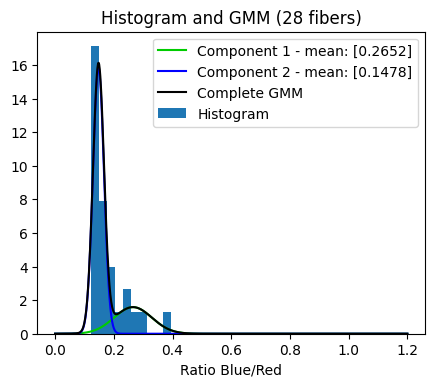

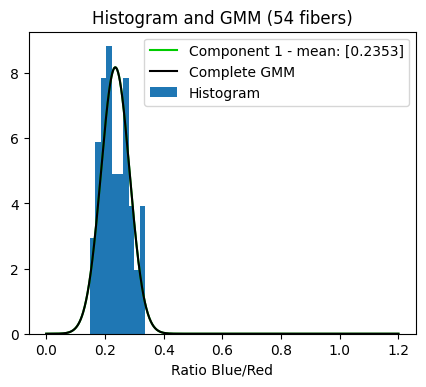

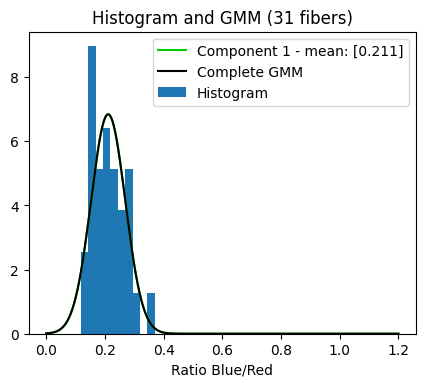

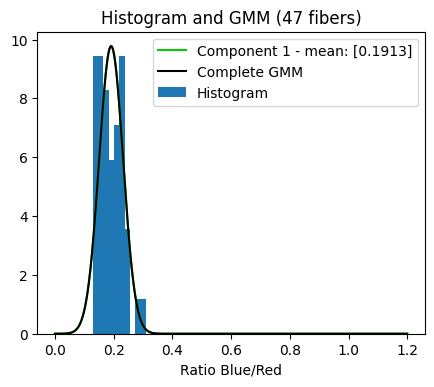

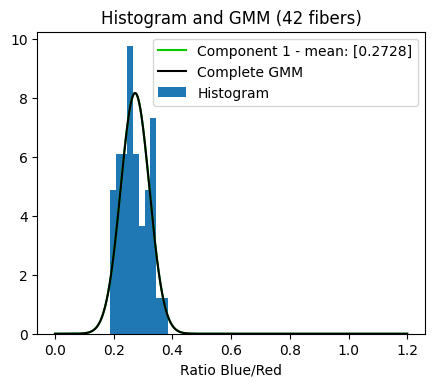

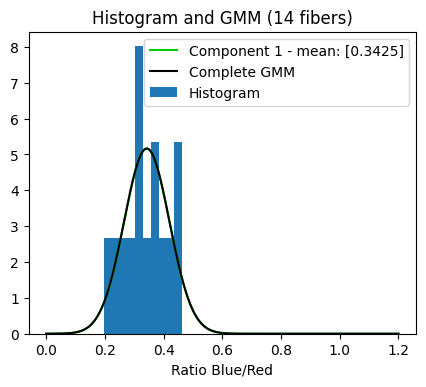

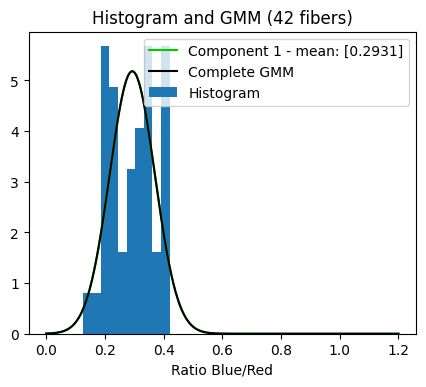

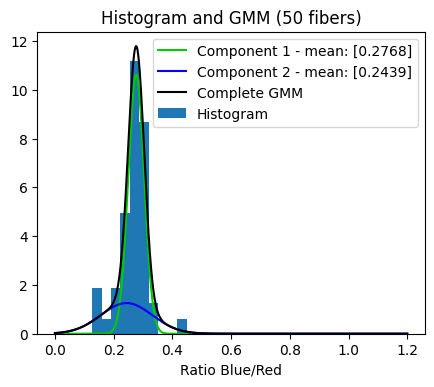

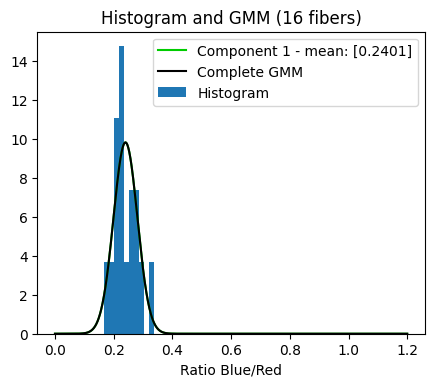

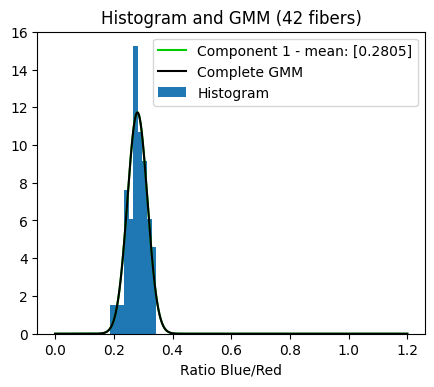

In [8]:
from model_tf_keras import *
from functions import *
from skimage import filters
from skimage import morphology
from joblib import dump, load
import os
import re
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

dirName = Path('/content/drive/My Drive/MITO_FIBERS_x63/Segmentation_Unet/Data/63x')
mask_folder = Path('/content/drive/My Drive/MITO_FIBERS_x63/Segmentation_Unet/Data/Segmentation_Masks/63x')
model_path = '/content/drive/My Drive/MITO_FIBERS_x63/Segmentation_Unet/Models/unet_10x63x_10ep_10ep_200steps.hdf5'
gmm_folder = '/content/drive/My Drive/MITO_FIBERS_x63/Segmentation_Unet/Models/Results_GMM'

# load CNN trained model:
model = unet()
model.load_weights(model_path)

listOfFiles = list()
for (dirpath, dirnames, filenames) in os.walk(dirName):
    listOfFiles += [os.path.join(dirpath, file) for file in filenames if file.endswith('.lif')]

# Group lif files by caso:
allcases = []
for filepath in listOfFiles:
  for m in re.finditer('Caso',filepath):
    ind1 = m.start()
    break
  ind2 = filepath.rfind('_',ind1,ind1+8)
  kcaso = filepath[ind1+4:ind2]
  #print('file: {}'.format(filepath))
  #print('caso = {}'.format(kcaso))
  allcases = np.append(allcases,int(kcaso))

indcasos = np.unique(allcases)

for kcaso in indcasos:
  print('Caso = {}'.format(str(int(kcaso))))
  mean_ratio_caso = []
  for filepath in listOfFiles:
      if filepath.endswith('.lif') & ('Caso'+str(int(kcaso))+'_' in filepath):
        print('Campo = {}'.format(filepath))
        r,b = readLIF(filepath)
        r = skimage.transform.resize(r, (256,256))
        b = skimage.transform.resize(b, (256,256))
        img = np.stack((r,b), axis = 2)
        img = np.reshape(img,(1,)+img.shape) 

        results = model.predict(img,verbose=1)
        seg_image = np.reshape(results,(256,256))
        seg_image = (seg_image*255).astype('uint8')
        # get mask:
        se = 3
        thresh = filters.threshold_otsu(seg_image)
        image = morphology.opening(seg_image > thresh, morphology.disk(se))
        # get B/R ratios:
        mean_ratio, label_image, fiberI = _ratio(r,b,image)
        nanI,fiberI1,mean_ratio1 = remove_nan(mean_ratio, fiberI)

        # append rations from all the fields:
        print('Added {} fibers in field {}'.format(mean_ratio1.shape[0],filepath))
        mean_ratio_caso = np.append(mean_ratio_caso,mean_ratio1)
        
        print('total number of fibers = {}'.format(mean_ratio_caso.shape[0]))
    # Fit GMM model to fiber ratios:
  (X, Y1, clf_means, clfI, clf) = fitGMM(mean_ratio_caso)
  #pred_gmm_image = pred_gmm(Y1,label_image,fiberI1)
  print('{} GMM clusters found in a total of {} fibers'.format(clf.n_components,mean_ratio_caso.shape[0]))
       
# save stuff
       # path, filename = os.path.split(filepath)
       # print('Filename: {}'.format(filename))
       # result_path = os.path.join(mask_folder,str(filename[:-4])+'.png')
       # print('Result Path: {}'.format(result_path))
       # #gmmodel_path = os.path.join(gmm_folder,str(filename[:-4])+'GMM.joblib')
       # #dump(clf, gmmodel_path)
  gmmodel_path = os.path.join(gmm_folder,'Caso'+str(int(kcaso)) +'GMM.png')
  showHistAndGMM_save(X,clf,clfI,clf_means,gmmodel_path)

        #try: 
        #    image = (image*255).astype('uint8')
        #    io.imsave(result_path,image)
        #    print('File saved: '+str(result_path))
        #except:
        #    print('Error')

In [10]:
mean_ratio_caso.shape

(278,)

In [16]:
indcasos

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
       28., 29.])

False

In [0]:
clf.n_components

1

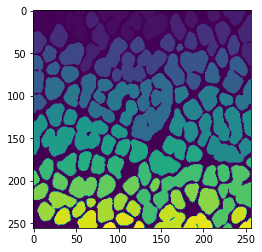

In [0]:
import matplotlib.pyplot as plt
plt.imshow(label_image)
plt.show()

In [0]:
mean_ratio.shape

(93,)

(array([ 1.,  3.,  6., 14., 20., 20., 13., 11.,  3.,  1.]),
 array([0.09130216, 0.11341139, 0.13552062, 0.15762985, 0.17973909,
        0.20184832, 0.22395755, 0.24606679, 0.26817602, 0.29028525,
        0.31239448]),
 <a list of 10 Patch objects>)

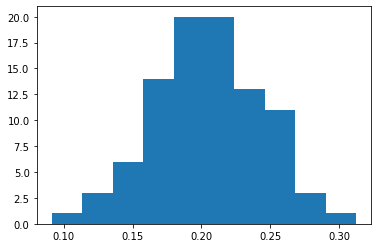

In [0]:
plt.hist(mean_ratio,10)

In [0]:
filepath = '/content/drive/My Drive/MITO_FIBERS_x63/Segmentation_Unet/Data/63x/Patients_Babies/Lif/Caso17_NDBFU8_Oxphos_Porin_C102.lif'

ind1 = filepath.rfind('Caso')
ind2 = filepath.rfind('_',ind1,ind1+8)
print(ind1)
print(ind2)
kcaso = filepath[ind1+4:ind2]

87
93


In [0]:
import re
filepath = '/content/drive/My Drive/MITO_FIBERS_x63/Segmentation_Unet/Data/63x/Patients_Babies/Lif/Caso17_NDBFU8_Oxphos_Porin_C102.lif'

dd = re.finditer('Caso',filepath)
dd.start(1)

AttributeError: ignored

In [0]:
[(m.start(0), m.end(0)) for m in re.finditer('Caso',filepath)]


[(87, 91)]

In [0]:
from model_tf_keras import *
from functions import *
from skimage import filters
from skimage import morphology
from joblib import dump, load

dirName = Path('/content/drive/My Drive/MITO_FIBERS_x63/Segmentation_Unet/Data/63x')
mask_folder = Path('/content/drive/My Drive/MITO_FIBERS_x63/Segmentation_Unet/Data/Segmentation_Masks/63x')
model_path = '/content/drive/My Drive/MITO_FIBERS_x63/Segmentation_Unet/Models/unet_10x63x_10ep_10ep_200steps.hdf5'
gmm_folder = '/content/drive/My Drive/MITO_FIBERS_x63/Segmentation_Unet/Models/Results_GMM'

listOfFiles = list()
for (dirpath, dirnames, filenames) in os.walk(dirName):
    listOfFiles += [os.path.join(dirpath, file) for file in filenames if file.endswith('.lif')]

In [0]:
import re
for filepath in listOfFiles:
  ind1 = filepath.rfind('Caso')
  ind2 = filepath.rfind('_',ind1,ind1+8)
  kcaso = filepath[ind1+4:ind2]
  print('file: {}'.format(filepath))
  print('caso = {}'.format(kcaso))
  allcases = np.append(allcases,caso)

'/content/drive/My Drive/MITO_FIBERS_x63/Segmentation_Unet/Data/63x/Control/Lif/Caso7_NDBFU8_Oxphos_Porin_C104.lif'

In [0]:
import numpy as np
import re

allcases = []

for filepath in listOfFiles:
  for m in re.finditer('Caso',filepath):
    ind1 = m.start()
    break
  ind2 = filepath.rfind('_',ind1,ind1+8)
  kcaso = filepath[ind1+4:ind2]
  print('file: {}'.format(filepath))
  print('caso = {}'.format(kcaso))
  allcases = np.append(allcases,int(kcaso))

file: /content/drive/My Drive/MITO_FIBERS_x63/Segmentation_Unet/Data/63x/Patients_Babies/Lif/Caso17_NDBFU8_Oxphos_Porin_C102.lif
caso = 17
file: /content/drive/My Drive/MITO_FIBERS_x63/Segmentation_Unet/Data/63x/Patients_Babies/Lif/Caso17_NDBFU8_Oxphos_Porin_C101.lif
caso = 17
file: /content/drive/My Drive/MITO_FIBERS_x63/Segmentation_Unet/Data/63x/Patients_Babies/Lif/Caso17_NDBFU8_Oxphos_Porin_C105.lif
caso = 17
file: /content/drive/My Drive/MITO_FIBERS_x63/Segmentation_Unet/Data/63x/Patients_Babies/Lif/Caso17_NDBFU8_Oxphos_Porin_C103.lif
caso = 17
file: /content/drive/My Drive/MITO_FIBERS_x63/Segmentation_Unet/Data/63x/Patients_Babies/Lif/Caso17_NDBFU8_Oxphos_Porin_C104.lif
caso = 17
file: /content/drive/My Drive/MITO_FIBERS_x63/Segmentation_Unet/Data/63x/Patients_Babies/Lif/Caso17_NDBFU8_Oxphos_Porin_C202.lif
caso = 17
file: /content/drive/My Drive/MITO_FIBERS_x63/Segmentation_Unet/Data/63x/Patients_Babies/Lif/Caso17_NDBFU8_Oxphos_Porin_C201.lif
caso = 17
file: /content/drive/My Dri

In [0]:
np.unique(allcases)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
       28., 29.])

In [0]:
len(listOfFiles)

180